# Проект "Определение стоимости автомобилей"

# Table of Contents
* [Описание проекта](#0.Описание)
    * [Цель проекта](#0.1.Цель)
    * [План работ](#0.2.План)
    * [Примечания к плану работ](#0.3.Прим)
    * [Данные](#0.3.Данные)
* [1. Подготовка данных](#1.Глава1)
    * [1.1. Импорт библиотек](#1.1.Импорт_библиотек)
    * [1.2. Определение констант](#1.2.Опред_констант)
    * [1.3. Загрузка данных](#1.3.Загрузка_данных)
    * [1.4. Дополнительная очистка](#1.4.Допочистка)
* [2. Подготовка наборов](#2.Подг_наборов)
    * [2.1. Разделение наборов на таргеты и признаки](#2.1.Таргет_Призн)
    * [2.2. Применение OneHotEncoder](#2.2.OHE)
    * [2.3. Разделение train, test ](#2.3.Train_test)
* [3. Обучение моделей](#3.Обучение_мод)
    * [3.1. Линейная регрессия](#3.1.LR)
    * [3.2. CatBoost](#3.2.CBR)
    * [3.3. LightGBM](#3.3.LGBM)
* [4. Вывод](#4.Вывод)

# Описание проекта <a class="anchor" id="0.Описание"></a>

## Цель проекта <a class="anchor" id="0.1.Цель"></a>

1. Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
2. Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
3. Критерии, которые важны заказчику:
        1. качество предсказания;
        2. время обучения модели;
        3. время предсказания модели.

## План работ <a class="anchor" id="0.2.План"></a>

1. Загрузите данные, путь к файлу:  /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.


## Примечания к плану работ <a class="anchor" id="0.2.Примечания"></a>

1. Для оценки качества моделей применяйте метрику RMSE.
2. Значение метрики RMSE должно быть меньше 2500.
3. Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
4. Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
5. Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
6. Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.


## Данные <a class="anchor" id="0.3.Данные"></a>

1. Признаки
2. DateCrawled — дата скачивания анкеты из базы
3. VehicleType — тип автомобильного кузова
4. RegistrationYear — год регистрации автомобиля
5. Gearbox — тип коробки передач
6. Power — мощность (л. с.)
7. Model — модель автомобиля
8. Kilometer — пробег (км)
9. RegistrationMonth — месяц регистрации автомобиля
10. FuelType — тип топлива
11. Brand — марка автомобиля
12. Repaired — была машина в ремонте или нет
13. DateCreated — дата создания анкеты
14. NumberOfPictures — количество фотографий автомобиля
15. PostalCode — почтовый индекс владельца анкеты (пользователя)
16. LastSeen — дата последней активности пользователя
17. Целевой признак
18. Price — цена (евро)

# 1. Загрузка и подготовка данных <a class="anchor" id="1.Глава1"></a>


## 1.1 Импорт библиотек <a class="anchor" id="1.1.Импорт_библиотек"></a>

In [1]:
import os

import time
from datetime import timedelta

import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 0)
#pd.set_option('display.width', 1000)
import numpy as np
from numpy.linalg import inv, cond

import random

from sklearn.datasets import make_spd_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

from scipy import stats as st
from seaborn import pairplot, heatmap,stripplot

from random import randrange

from sklearn.inspection import permutation_importance



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1.2 Определение констант <a class="anchor" id="1.2.Опред_констант"></a>

In [2]:

RANDOM_STATE = 27182
state = np.random.RandomState(RANDOM_STATE)


## 1.3 Загрузка и проверка данных <a class="anchor" id="1.3.Загрузка_данных"></a>

1. Загружаем данные.
2. Проверяем на NaN, мультиколинерность, дублирование категориальных признаков, лишние данные/столбцы.
3. Убираем дублирование.

In [3]:
try:
    df = pd.read_csv(r'C:\Users\e_rotar\Documents\yp\pr11\datasets\autos.csv',
                     parse_dates=['DateCrawled', 'DateCreated'])
    print('Загрузился Path Windows!')
except Exception:
    print('Это не Windows!')
    
try:
    df = pd.read_csv(r'/datasets/insurance.csv')
    print('Загрузился Path Yandex!')

except Exception:
    print('Это не Yandex!')    


Загрузился Path Windows!
Это не Yandex!


Функция проверки:
1. пропуски и NaN
2. мультиколинерность
3. графики
4. лишние данные/столбцы

In [4]:

def about_df(df,sample_size=5, graph = False):
    print(f'Первые {sample_size} строк')
    display(df.head(sample_size))
    print(f'Последние {sample_size} строк')
    display(df.tail(sample_size))
    print(f'\n Основная информация')
    print(df.info())
    #display(df.describe(include='all'))
    print(f'\n Корреляции')
    display(df.corr())
    
    if graph:
        #df.hist(figsize=(10,10))
        heatmap(df.corr(), annot=True, square=True, center=0, fmt='.1g')
        pairplot(data = df)
        #g.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.show()
    
    print(f'\n Кол-во и доля пропусков')
    
    display(
        pd.DataFrame(
            np.array([df.isna().sum(), df.isna().mean()]).T,
            columns = ['кол-во пропусков','доля пропусков'],
            index=df.columns
        ).style.background_gradient('coolwarm')
    )
    
    print(f'\n Кол-во и доля дубликатов')
    
    display( df.duplicated().head() )
    print(1 - df.duplicated().value_counts()/len(df) )

1. Проверяем df
2. Функция проверки NaN, мультиколинерность, дублирование категориальных признаков, лишние данные/столбцы.

In [5]:

about_df(df)


Первые 5 строк


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Последние 5 строк


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20,0,40764,2016-03-24 12:45:21



 Основная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000



 Кол-во и доля пропусков


,кол-во пропусков,доля пропусков
DateCrawled,0.000000,0.000000
Price,0.000000,0.000000
VehicleType,37490.000000,0.105794
RegistrationYear,0.000000,0.000000
Gearbox,19833.000000,0.055967
Power,0.000000,0.000000
Model,19705.000000,0.055606
Kilometer,0.000000,0.000000
RegistrationMonth,0.000000,0.000000
FuelType,32895.000000,0.092827



 Кол-во и доля дубликатов


0    False
1    False
2    False
3    False
4    False
dtype: bool

False    0.000011
True     0.999989
dtype: float64


1. DateCrawled — дата скачивания анкеты из базы, удаляем
2. DateCreated — дата создания анкеты, удаляем
3. NumberOfPictures — количество фотографий автомобиля, удаляем
4. PostalCode — почтовый индекс владельца анкеты (пользователя), удаляем
5. LastSeen — дата последней активности пользователя, удаляем
6. Остальные NaN заменяем на 'unknown'

In [96]:
df.shape

(326826, 11)

## 1.4. Дополнительная очистка <a class="anchor" id="1.4.Допочистка"></a>

1. Построим бокс плоты для:
2. Price
3. RegistrationYear
4. Power
5. Kilometer
6. RegistrationMonth
7. По итогу уберем одиозные выбросы


 График числовых данных


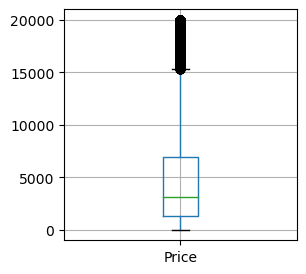

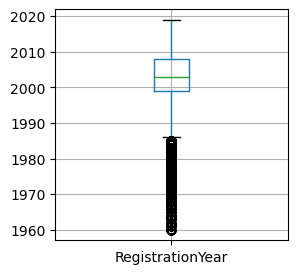

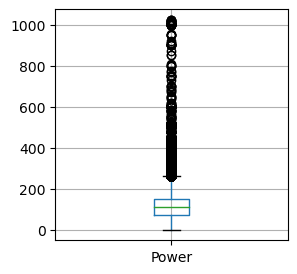

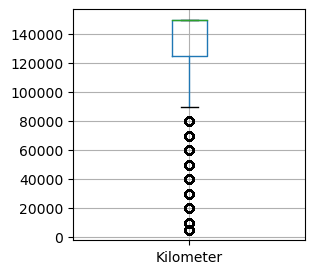

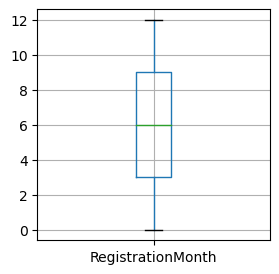

In [8]:
#df.hist(figsize=(10,10))
print(f'\n График числовых данных')
df[['Price']].boxplot(figsize=(3,3))
plt.show()

df[['RegistrationYear']].boxplot(figsize=(3,3))
plt.show()

df[['Power']].boxplot(figsize=(3,3))
plt.show()

df[['Kilometer']].boxplot(figsize=(3,3))
plt.show()

df[['RegistrationMonth']].boxplot(figsize=(3,3))
plt.show()

1. 'Price' - ОК

2. 'RegistrationYear' - рассматриваем с 1960 по 2021г
3. 'Power' - смотрим не более 1050лс.
4. 'Kilometer' - ОК
5. 'RegistrationMonth' - ОК

In [14]:
df = df[(df['RegistrationYear'] <= df['DateCrawled'].dt.year) &
        (df['RegistrationYear'] <= df['DateCreated'].dt.year) &
        (df['RegistrationYear'] <= 2021) &
        (df['RegistrationYear'] >= 1960)  &
        (df['Power'] <=1050) &
        (df['Power'] > 0) &
        (df['Price'] > 1)
       ]


df.shape

(295855, 16)

In [15]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns')
df = df.fillna("unknown")
df =df.drop_duplicates()

In [16]:
df.shape

(272742, 11)

In [17]:

about_df(df)


Первые 5 строк


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


Последние 5 строк


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
354361,5250,unknown,2016,auto,150,159,150000,12,unknown,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no
354368,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,unknown



 Основная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 272742 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              272742 non-null  int64 
 1   VehicleType        272742 non-null  object
 2   RegistrationYear   272742 non-null  int64 
 3   Gearbox            272742 non-null  object
 4   Power              272742 non-null  int64 
 5   Model              272742 non-null  object
 6   Kilometer          272742 non-null  int64 
 7   RegistrationMonth  272742 non-null  int64 
 8   FuelType           272742 non-null  object
 9   Brand              272742 non-null  object
 10  Repaired           272742 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.0+ MB
None


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
count,272742.000000,272742,272742.000000,272742,272742.000000,272742,272742.000000,272742.000000,272742,272742,272742
unique,NaN,9,NaN,3,NaN,250,NaN,NaN,8,40,3
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,75995,NaN,213570,NaN,22435,NaN,NaN,172556,58321,204845
mean,4842.207944,NaN,2002.808805,NaN,120.668001,NaN,128253.624304,5.974236,NaN,NaN,NaN
std,4613.710721,NaN,6.485736,NaN,55.371694,NaN,36812.848476,3.588166,NaN,NaN,NaN
min,2.000000,NaN,1960.000000,NaN,1.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,1300.000000,NaN,1999.000000,NaN,75.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN
50%,3190.000000,NaN,2003.000000,NaN,110.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN
75%,6990.000000,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN



 Корреляции


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.486458,0.490154,-0.381579,0.068389
RegistrationYear,0.486458,1.000000,0.125475,-0.288940,0.045577
Power,0.490154,0.125475,1.000000,0.107769,0.038882
Kilometer,-0.381579,-0.288940,0.107769,1.000000,-0.013562
RegistrationMonth,0.068389,0.045577,0.038882,-0.013562,1.000000



 Кол-во и доля пропусков


,кол-во пропусков,доля пропусков
Price,0.000000,0.000000
VehicleType,0.000000,0.000000
RegistrationYear,0.000000,0.000000
Gearbox,0.000000,0.000000
Power,0.000000,0.000000
Model,0.000000,0.000000
Kilometer,0.000000,0.000000
RegistrationMonth,0.000000,0.000000
FuelType,0.000000,0.000000
Brand,0.000000,0.000000



 Кол-во и доля дубликатов


1    False
2    False
3    False
4    False
5    False
dtype: bool

False    0.0
dtype: float64


# 2. Подготовка наборов <a class="anchor" id="2.Подг_наборов"></a>

## 2.1. Разделение наборов на таргеты и признаки <a class="anchor" id="2.1.Таргет_Призн"></a>

1. Выделим таргет из выборки
2. Важное замечание, для меня :) . Если мы разделим сразу на train, valid, test то есть шанс, что редкие признаки могут не попасть в набор, и при OHE получиться разное кол-во столбцов.
3. И наоборт, если мы сделаем OHE до разделения на train, valid, test, тогда может быть, что в valid или в test редкий признак может и не попасть. Но хотя-бы кол-во столбцов будет норм.

In [18]:

X_ = df.drop('Price', axis = 1) #  признаки
y_ = df['Price'] #  целевой признак
print(X_.info())
#about_df(X_)
display(X_)
display(y_)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 272742 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        272742 non-null  object
 1   RegistrationYear   272742 non-null  int64 
 2   Gearbox            272742 non-null  object
 3   Power              272742 non-null  int64 
 4   Model              272742 non-null  object
 5   Kilometer          272742 non-null  int64 
 6   RegistrationMonth  272742 non-null  int64 
 7   FuelType           272742 non-null  object
 8   Brand              272742 non-null  object
 9   Repaired           272742 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.9+ MB
None


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,unknown,2016,auto,150,159,150000,12,unknown,alfa_romeo,no
354362,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


1         18300
2          9800
3          1500
4          3600
5           650
          ...  
354361     5250
354362     3200
354366     1199
354367     9200
354368     3400
Name: Price, Length: 272742, dtype: int64

## 2.2. Применение OneHotEncoder<a class="anchor" id="2.2.OHE"></a>


1. делаем набору OHE до выделения train, valid


In [19]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first') #удаляем первый столбец чтобы не попасть в дамми-ловушку
cat = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

X_ohe_ = pd.DataFrame(
    encoder.fit_transform(X_[cat]).toarray(),
    columns=encoder.get_feature_names_out(),
    index=X_.index
)
    
X_ohe_ = pd.concat([X_, X_ohe_], ignore_index=False, join='inner',axis=1)
display(X_ohe_.head())
X_ohe_ = X_ohe_.drop(cat,axis=1)
display(X_ohe_.head())
display(y_.head())
print(X_ohe_.shape)
print(X_.shape)
print(y_.shape)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,...,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,...,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,2011,190,125000,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2004,163,125000,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2001,75,150000,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2008,69,90000,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1995,102,150000,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

1    18300
2     9800
3     1500
4     3600
5      650
Name: Price, dtype: int64

(272742, 311)
(272742, 10)
(272742,)


## 2.3. Разделение train, test <a class="anchor" id="2.3.Train_test"></a>

1. Выделим train
2. Не выделяем valid будем делать кросс валидацию на нормальных регрессорах
3. Выделим test
4. сделаем Display, проверяем для себя, что номера строк признаков3 и таргета  совпадают

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_, y_, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = train_test_split(
    X_ohe_, y_, test_size=0.2, random_state=RANDOM_STATE)
X_ohe_train, X_ohe_valid, y_ohe_train, y_ohe_valid = train_test_split(
    X_ohe_train, y_ohe_train, test_size=0.25, random_state=RANDOM_STATE)

display('X_train.head()',X_train.head(), y_train.head())
display('X_ohe_train.head()',X_ohe_train.head(), y_ohe_train.head())

display('X_valid.head()', X_valid.head(), y_valid.head())
display('X_ohe_valid.head()', X_ohe_valid.head(), y_ohe_valid.head())

display('X_test.head()', X_test.head(), y_test.head())
display('X_ohe_test.head()', X_ohe_test.head(), y_ohe_test.head())

print('X_train.shape =', X_train.shape, 'y_train.shape =', y_train.shape)
print('X_ohe_train.shape =', X_ohe_train.shape, 'y_ohe_train.shape =', y_ohe_train.shape)

print('X_valid.shape =', X_valid.shape, 'y_valid.shape =', y_valid.shape)
print('X_ohe_valid.shape =', X_ohe_valid.shape, 'y_ohe_valid.shape =', y_ohe_valid.shape)

print('X_test.shape =', X_test.shape, 'y_test.shape =', y_test.shape)
print('X_ohe_test.shape =', X_ohe_test.shape, 'y_ohe_test.shape =', y_ohe_test.shape)

'X_train.head()'

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
66767,small,1998,auto,75,polo,150000,9,petrol,volkswagen,no
323362,sedan,2003,manual,82,a_klasse,80000,9,petrol,mercedes_benz,no
332179,wagon,2002,manual,150,156,150000,1,petrol,alfa_romeo,unknown
78472,small,1999,manual,50,unknown,150000,5,petrol,volkswagen,no
276504,wagon,2004,auto,131,a4,150000,0,unknown,audi,unknown


66767     1750
323362    3500
332179    1200
78472     1000
276504    3799
Name: Price, dtype: int64

'X_ohe_train.head()'

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,...,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
66767,1998,75,150000,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
323362,2003,82,80000,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332179,2002,150,150000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
78472,1999,50,150000,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
276504,2004,131,150000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

66767     1750
323362    3500
332179    1200
78472     1000
276504    3799
Name: Price, dtype: int64

'X_valid.head()'

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
68435,sedan,1969,manual,54,other,125000,3,petrol,renault,no
195956,suv,2008,manual,170,tiguan,100000,4,gasoline,volkswagen,no
99401,small,2001,manual,116,cooper,150000,11,petrol,mini,no
141605,sedan,2005,manual,140,golf,150000,3,gasoline,volkswagen,yes
289026,suv,1998,auto,144,grand,150000,3,petrol,suzuki,no


68435      8000
195956    17700
99401      4250
141605     2000
289026     2900
Name: Price, dtype: int64

'X_ohe_valid.head()'

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,...,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
68435,1969,54,125000,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195956,2008,170,100000,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99401,2001,116,150000,11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141605,2005,140,150000,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
289026,1998,144,150000,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

68435      8000
195956    17700
99401      4250
141605     2000
289026     2900
Name: Price, dtype: int64

'X_test.head()'

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
100960,small,2009,auto,98,fortwo,80000,3,petrol,smart,no
270778,unknown,2005,manual,109,unknown,150000,0,unknown,peugeot,unknown
130210,sedan,2005,manual,101,astra,150000,2,gasoline,opel,no
127718,sedan,1995,manual,101,a4,150000,5,petrol,audi,yes
340953,small,2001,manual,58,corsa,150000,4,petrol,opel,no


100960    7800
270778    2699
130210    2750
127718    1900
340953     800
Name: Price, dtype: int64

'X_ohe_test.head()'

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,...,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
100960,2009,98,80000,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270778,2005,109,150000,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
130210,2005,101,150000,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127718,1995,101,150000,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
340953,2001,58,150000,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

100960    7800
270778    2699
130210    2750
127718    1900
340953     800
Name: Price, dtype: int64

X_train.shape = (163644, 10) y_train.shape = (163644,)
X_ohe_train.shape = (163644, 311) y_ohe_train.shape = (163644,)
X_valid.shape = (54549, 10) y_valid.shape = (54549,)
X_ohe_valid.shape = (54549, 311) y_ohe_valid.shape = (54549,)
X_test.shape = (54549, 10) y_test.shape = (54549,)
X_ohe_test.shape = (54549, 311) y_ohe_test.shape = (54549,)


1. Проверили, вроде все гармонирует.

# 3. Обучение и  тестирование моделей <a class="anchor" id="3.Обучение_мод"></a>

## 3. 3.1. Линейная регрессия <a class="anchor" id="3.1.LR"></a>

In [21]:
#Линейная регрессия

lr_model = LinearRegression()

In [24]:
#%%time

start_time = time.time()

lr_model.fit(X_ohe_train, y_ohe_train)

fit_time = time.time() - start_time


In [26]:
#%%time

start_time = time.time()

y_ohe_valid_pred = pd.Series(lr_model.predict(X_ohe_valid))

pred_time = time.time() - start_time


In [27]:
#%%time

score_ = mean_squared_error(y_ohe_valid, y_ohe_valid_pred)**0.5
print(f' best_score: {score_}')
print('fit_time = ', fit_time)
print('pred_time = ', pred_time)
models_scores = [['LinearRegression',score_, fit_time, pred_time]]
#models_scores.append(['LinearRegression',score_, fit_time])
display(models_scores)


 best_score: 2621.982108575703
fit_time =  5.588212013244629
pred_time =  0.16090703010559082


[['LinearRegression',
  2621.982108575703,
  5.588212013244629,
  0.16090703010559082]]

## 3.2.CatBoost регрессор <a class="anchor" id="3.2.CBR"></a>

1. Теперь, cast boost

In [30]:
%%time
# CatBoost регрессор 

learn_rate_min = 0.1
learn_rate_max = 0.7

depth_min = 3
depth_max = 20

best_model = None
best_score = 10000000
best_iter = 0
best_learn_rate = 0
best_depth = 0

for i in range(1,8):
    print(f'Итерация - {i}')
#    iter_ = randrange(iter_min, iter_max)
#    depth_ = randrange(depth_min, depth_max)
#    verb_ = randrange(verb_min, verb_max)
#    iter_ = 12
#    depth_ = 12
    learn_rate_ = learn_rate_min + 0.1*i

    params = {'n_estimators': 100,
              'loss_function':'RMSE',
              'learning_rate': learn_rate_,
              'depth': 12,
              'random_state': RANDOM_STATE,
              'verbose': 2,
              'cat_features': cat}
    model = CatBoostRegressor(**params).fit(X_train,y_train)
    y_valid_pred = model.predict(X_valid)
    score_ = mean_squared_error(y_valid, y_valid_pred)**0.5
    if score_ < best_score:
        best_cat_model = model
        best_score = score_
        best_iter = i
        best_learn_rate = learn_rate_
#        best_depth = 0

print(f' best_score: {best_score}, best_iter: {i}, best_learn_rate: {best_learn_rate}')



Итерация - 1
0:	learn: 3950.0065584	total: 295ms	remaining: 29.2s
2:	learn: 3048.4027251	total: 1.07s	remaining: 34.7s
4:	learn: 2531.6616277	total: 1.62s	remaining: 30.7s
6:	learn: 2205.6424541	total: 2.16s	remaining: 28.7s
8:	learn: 2011.5066220	total: 2.69s	remaining: 27.2s
10:	learn: 1888.1234167	total: 3.42s	remaining: 27.7s
12:	learn: 1812.3594802	total: 4s	remaining: 26.8s
14:	learn: 1747.8714460	total: 4.55s	remaining: 25.8s
16:	learn: 1711.1660824	total: 5.08s	remaining: 24.8s
18:	learn: 1685.8929708	total: 5.61s	remaining: 23.9s
20:	learn: 1660.9214016	total: 6.14s	remaining: 23.1s
22:	learn: 1650.2897011	total: 6.69s	remaining: 22.4s
24:	learn: 1637.8818580	total: 7.25s	remaining: 21.8s
26:	learn: 1622.9600457	total: 7.78s	remaining: 21s
28:	learn: 1611.4523912	total: 8.31s	remaining: 20.3s
30:	learn: 1603.5006893	total: 8.86s	remaining: 19.7s
32:	learn: 1594.5516222	total: 9.4s	remaining: 19.1s
34:	learn: 1585.8701322	total: 9.93s	remaining: 18.4s
36:	learn: 1577.7071553	to

In [31]:
# %%time

start_time = time.time()
params = {'n_estimators': 100,
          'loss_function':'RMSE',
          'learning_rate': best_learn_rate,
          'depth': 12,
          'random_state': RANDOM_STATE,
          'verbose': 2,
          'cat_features': cat}
best_cat_model = CatBoostRegressor(**params).fit(X_train,y_train)
fit_time = time.time() - start_time



0:	learn: 3636.0885401	total: 336ms	remaining: 33.2s
2:	learn: 2594.0127600	total: 999ms	remaining: 32.3s
4:	learn: 2123.3816717	total: 1.53s	remaining: 29.2s
6:	learn: 1902.8883048	total: 2.06s	remaining: 27.3s
8:	learn: 1803.8422230	total: 2.57s	remaining: 26s
10:	learn: 1730.3976056	total: 3.11s	remaining: 25.2s
12:	learn: 1693.0999656	total: 3.63s	remaining: 24.3s
14:	learn: 1666.8737640	total: 4.16s	remaining: 23.6s
16:	learn: 1648.7643287	total: 4.68s	remaining: 22.8s
18:	learn: 1629.3355592	total: 5.2s	remaining: 22.2s
20:	learn: 1615.9845324	total: 5.72s	remaining: 21.5s
22:	learn: 1600.1625953	total: 6.25s	remaining: 20.9s
24:	learn: 1587.1415167	total: 6.77s	remaining: 20.3s
26:	learn: 1575.7612123	total: 7.28s	remaining: 19.7s
28:	learn: 1566.1051890	total: 7.79s	remaining: 19.1s
30:	learn: 1552.0660591	total: 8.35s	remaining: 18.6s
32:	learn: 1541.6008751	total: 8.88s	remaining: 18s
34:	learn: 1536.0552610	total: 9.41s	remaining: 17.5s
36:	learn: 1526.3866976	total: 9.93s	r

In [33]:
#%%time
start_time = time.time()
y_valid_pred = best_cat_model.predict(X_valid)
pred_time = time.time() - start_time


In [34]:
#%%time
score_ = mean_squared_error(y_valid, y_valid_pred)**0.5
print(f' best_score: {score_}')
print('fit_time = ', fit_time)
print('pred_time = ', pred_time)
models_scores.append(['CatBoost',score_, fit_time, pred_time])
display(models_scores)


 best_score: 1586.3993711891112
fit_time =  28.43289875984192
pred_time =  0.2548532485961914


[['LinearRegression',
  2621.982108575703,
  5.588212013244629,
  0.16090703010559082],
 ['CatBoost', 1586.3993711891112, 28.43289875984192, 0.2548532485961914]]

Wall time: 8 ms


## 3.3. LightGBM <a class="anchor" id="3.3.LGBM"></a>

In [40]:
%%time

print(cat)
print(X_train.info())

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 163644 entries, 66767 to 352331
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        163644 non-null  object
 1   RegistrationYear   163644 non-null  int64 
 2   Gearbox            163644 non-null  object
 3   Power              163644 non-null  int64 
 4   Model              163644 non-null  object
 5   Kilometer          163644 non-null  int64 
 6   RegistrationMonth  163644 non-null  int64 
 7   FuelType           163644 non-null  object
 8   Brand              163644 non-null  object
 9   Repaired           163644 non-null  object
dtypes: int64(4), object(6)
memory usage: 13.7+ MB
None
Wall time: 421 ms


In [2]:
%%time

best_score = 1e12
best_nleaves = 2
nleaves_min = 4095
nleaves_max = 8193
best_iter = 100
best_rate = 0.5

X_train_lgbm = X_train
X_valid_lgbm = X_valid
X_test_lgbm = X_test    

for c in cat:
    X_train_lgbm[c] =  X_train[c].astype('category')
    X_valid_lgbm[c] =  X_valid[c].astype('category')
    X_test_lgbm[c] =  X_test[c].astype('category')

for i in range(1,8):
    nleaves_ = 1024*i
    params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'metric': 'rmse',
              'max_depth': 20,
              'learning_rate': 0.5,
              'verbose': 2,
              'num_leaves': nleaves_,
              'force_row_wise': True,
              'categorical_feature': cat
             }
#    model = LGBMRegressor(categorical_feature= cat)
#    model = LGBMRegressor(categorical_feature= [0,2,4,7,8,9]) 
    model = LGBMRegressor(**params)
    model.fit(X_train_lgbm, y_train)
    y_valid_pred = pd.Series(model.predict(X_valid_lgbm))
    score_ = mean_squared_error(y_valid, y_valid_pred)**0.5
    if score_ < best_score:
        best_lgbm_model = model
        best_iter = i
        best_score = score_
        best_nleaves =  nleaves_

print(f' best_score: {best_score}, best_iter: {i}, best_nleaves: {best_nleaves}')


best_score: 1674.1941318608374, best_iter: 7, best_nleaves: 1024 
 Wall time: 1min 32s
Wall time: 0 ns


In [48]:
### start_time = time.time()

start_time = time.time()

params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 20,
          'learning_rate': 0.5,
          'verbose': 2,
          'num_leaves': nleaves_,
          'force_row_wise': True} 

model = LGBMRegressor(**params)
model.fit(X_train_lgbm, y_train)

fit_time = time.time() - start_time         


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.169548
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 163644, number of used features: 10
[LightGBM] [Info] Start training from score 4844.126904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5355 and depth = 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5272 and depth = 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5061 and depth = 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4760 and depth = 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4093 and depth = 20
[LightGBM] [Warning] No f

In [49]:
### start_time = time.time()

start_time = time.time()
y_valid_pred = pd.Series(model.predict(X_valid_lgbm))

pred_time = time.time() - start_time         


In [50]:
#%%time
score_ = mean_squared_error(y_valid, y_valid_pred)**0.5
print(f' best_score: {score_}')
print('fit_time = ', fit_time)
print('pred_time = ', pred_time)
models_scores.append(['LGBM',score_, fit_time, pred_time])
display(models_scores)


 best_score: 1684.6309205319262
fit_time =  14.230289936065674
pred_time =  1.6222383975982666


[['LinearRegression',
  2621.982108575703,
  5.588212013244629,
  0.16090703010559082],
 ['CatBoost', 1586.3993711891112, 28.43289875984192, 0.2548532485961914],
 ['LGBM', 1684.6309205319262, 14.230289936065674, 1.6222383975982666]]

In [52]:

models_scores = pd.DataFrame(data = models_scores,columns = ('model','rmse','fit_time','pred_time'))


In [53]:

display(models_scores)

,model,rmse,fit_time,pred_time
0,LinearRegression,2621.982109,5.588212,0.160907
1,CatBoost,1586.399371,28.432899,0.254853
2,LGBM,1684.630921,14.230290,1.622238


In [56]:
%%time
#CatBoost получается лучшим


params = {'n_estimators': 100,
          'loss_function':'RMSE',
          'learning_rate': best_learn_rate,
          'depth': 12,
          'random_state': RANDOM_STATE,
          'verbose': 2,
          'cat_features': cat}
    
y_test_pred = best_cat_model.predict(X_test)
score_ = mean_squared_error(y_test, y_test_pred)**0.5
print(f' Тестовая метрика CatBoost: {score_}')

 Тестовая метрика CatBoost: 1574.3333244130413
Wall time: 161 ms


# 4. Вывод <a class="anchor" id="4.Вывод"></a>

1. Для решения задачи сделана предобработка данных. Произведена очистка, убраны дубликаты и шипы.
2. Подготовлены категориальные данные (OHE преобразование)
3. Произвено разделение на признаки и таргеты, выделены наборы - train
3. Для оценки алгоритом использовано 3 алгоритма - Линейный, CatBoost, LightGBM.
4. Минимальная метрика RMSE (как на валиде, так и на тесте кстати) - достигнута на алгоритме CatBoost
5. Минимальное время обучения модели (для RMSE < 2500) - достигнуто на алгоритме LightGBM
6. Минимальное время расчета валидных и тестовых предсказаний достигнуто на алгоритме CatBoost.
7. Рекомендуется в прод....